## Load NASBench library and dataset

In [1]:
from nasbench import api

# Use nasbench_full.tfrecord for full dataset 
nasbench = api.NASBench('D:\\Data\\nasbench_only108.tfrecord')

Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 22 seconds


运行200次，搜索深度150个结构，与论文的结果表进行对比

In [ ]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from search import randomSearch, evolutionSearch, SASearch
from search import randomSearch
N_RUNS = 500
errs = []

for _ in range(N_RUNS):
    rs = randomSearch(nasbench, return_mode="final_test_error")
    errs.append(rs.run())

mean_err = 100 * np.mean(errs)
std_err  = 100 * np.std(errs)

print(f"Random Search: {mean_err:.3f} ± {std_err:.3f}")
for _ in range(N_RUNS):
    es = evolutionSearch(
    nasbench,
    population_size=50,
    tournament_size=10,
    mutation_rate=1.0,
    crossover_rate=0.01,   
    return_mode="final_test_error",
    max_evals=150
)

    errs.append(es.run())
mean_err = 100 * np.mean(errs)
std_err  = 100 * np.std(errs)
print(f"Evolution Search: {mean_err:.3f} ± {std_err:.3f}")
for _ in range(N_RUNS):
    sa = SASearch(nasbench,    initial_temp=0.03,
    alpha=0.997,
    mutation_rate=0.3,
    max_time_budget=5e6, return_mode="final_test_error")
    errs.append(sa.run())
mean_err = 100 * np.mean(errs)
std_err  = 100 * np.std(errs)
print(f"Simulated Annealing: {mean_err:.3f} ± {std_err:.3f}")

Random Search: 6.269 ± 0.254
Evolution Search: 6.197 ± 0.245
Simulated Annealing: 6.226 ± 0.259


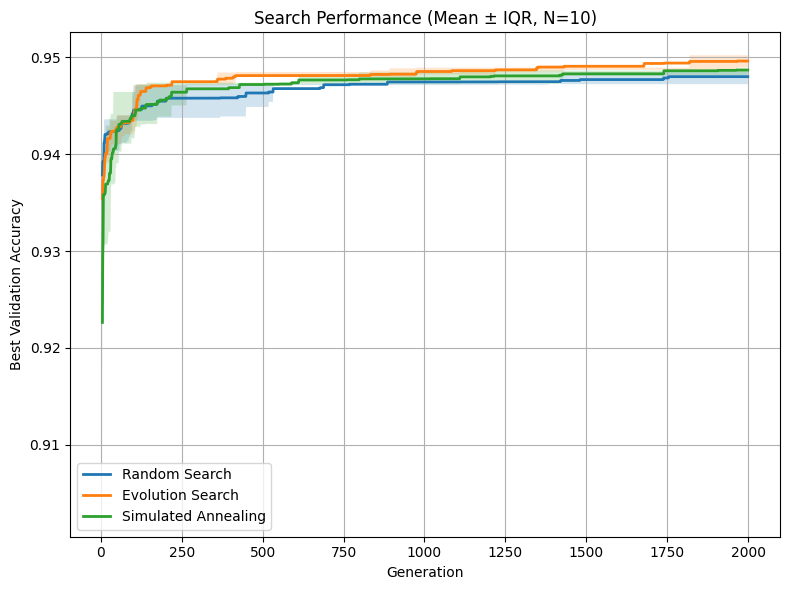

In [ ]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from search import randomSearch, evolutionSearch, SASearch
def ensure_2d(x):
    """确保输入是二维数组"""
    x = np.asarray(x)
    if x.ndim == 1:
        x = x.reshape(-1, 1)
    return x
N_REPEAT = 10
SKIP = 5
MAX_GEN = 2000

# 收集多次运行结果（安全数值版）
def collect_best_valid(search_cls, **run_kwargs):
    all_vals = []

    for i in range(N_REPEAT):
        seed = int(time.time()) + i
        random.seed(seed)
        np.random.seed(seed)

        search_args = {}
        search_kwargs = {}
        for key, value in run_kwargs.items():
            if key in ['crossover']:  
                search_args[key] = value
            elif key in ['initial_temp', 'alpha', 'mutation_rate', 'max_time_budget']:  # SASearch 参数
                search_kwargs[key] = value
        
        if search_kwargs: 
            search = search_cls(nasbench, **search_kwargs)
        else:
            search = search_cls(nasbench)
            
        _, best_valid, best_test = search.run(**search_args)
        seq = np.asarray(best_valid[SKIP:MAX_GEN], dtype=float)
        all_vals.append(seq)

    # 对齐长度
    T = min(len(v) for v in all_vals)
    all_vals = [v[:T] for v in all_vals]

    return np.stack(all_vals, axis=0)   
#初始化三个搜索类
vals_r  = collect_best_valid(randomSearch)
vals_e  = collect_best_valid(evolutionSearch,
    population_size=50,
    tournament_size=10,
    mutation_rate=1.0,
    crossover_rate=0.1,   
    max_evals=150)
vals_sa = collect_best_valid(SASearch, 
    initial_temp=0.03,
    alpha=0.997,
    mutation_rate=0.3,
    max_time_budget=5e6
)


vals_r  = ensure_2d(np.vstack(vals_r))
vals_e  = ensure_2d(np.vstack(vals_e))
vals_sa = ensure_2d(np.vstack(vals_sa))

T = min(vals_r.shape[-1], vals_e.shape[-1], vals_sa.shape[-1])
xs = np.arange(SKIP, SKIP + T)

vals_r  = vals_r[:, :T]
vals_e  = vals_e[:, :T]
vals_sa = vals_sa[:, :T]

# 统计：Mean + IQR

def mean_iqr(arr):
    mean = np.mean(arr, axis=0)
    q25  = np.percentile(arr, 25, axis=0)
    q75  = np.percentile(arr, 75, axis=0)
    return mean, q25, q75

mean_r, q25_r, q75_r = mean_iqr(vals_r)
mean_e, q25_e, q75_e = mean_iqr(vals_e)
mean_sa, q25_sa, q75_sa = mean_iqr(vals_sa)

plt.figure(figsize=(8, 6))

plt.plot(xs, mean_r, label="Random Search", linewidth=2)
plt.fill_between(xs, q25_r, q75_r, alpha=0.2)

plt.plot(xs, mean_e, label="Evolution Search", linewidth=2)
plt.fill_between(xs, q25_e, q75_e, alpha=0.2)

plt.plot(xs, mean_sa, label="Simulated Annealing", linewidth=2)
plt.fill_between(xs, q25_sa, q75_sa, alpha=0.2)

plt.xlabel("Generation")
plt.ylabel("Best Validation Accuracy")
plt.title("Search Performance (Mean ± IQR, N=10)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


多目标优化，进行测试，共同优化模型训练时间，模型参数，准确率三个目标

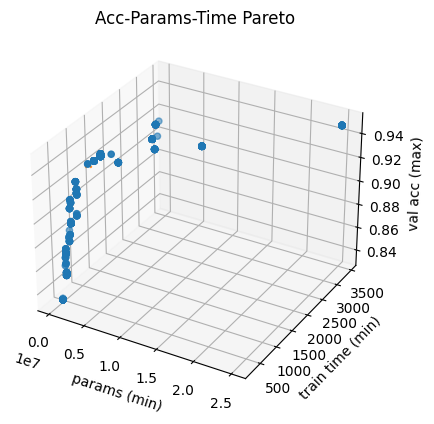

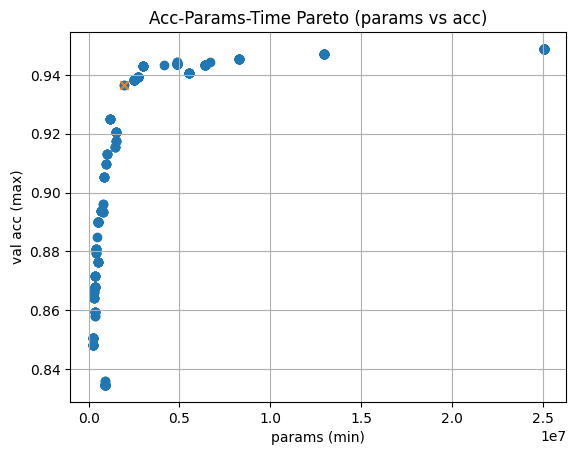

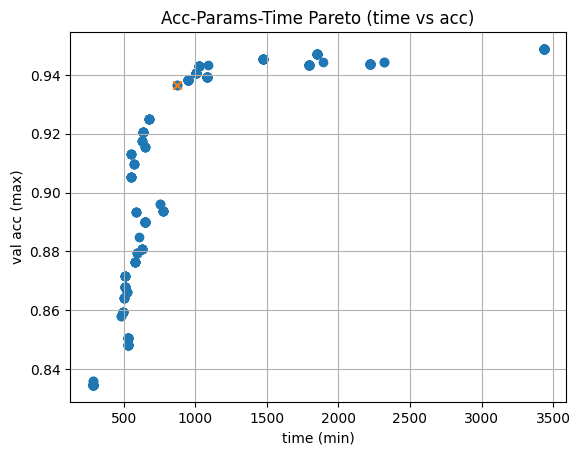

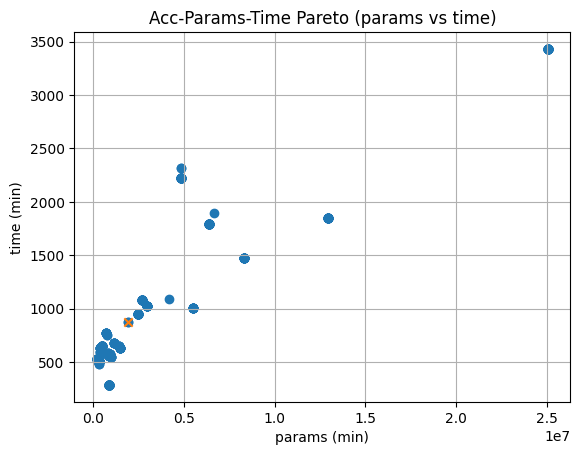

In [ ]:
from moea import MOEASearch
# acc + params + time
moea = MOEASearch(nasbench, use_params=True, use_time=True, pop_size=100, max_time_budget=5e6)
hist, arch, pop = moea.run()
MOEASearch.plot_pareto(arch, use_params=True, use_time=True, title="Acc-Params-Time Pareto")